# Classification with an Academic Success Dataset

The academic success dataset includes information related to students' academic paths, demographics and social-economic factors at the time of enrollment in university. The objective of this classification problem is to predict the enrollment status of each student at the end of the normal duration of their course, which can be one of the following:

- Dropout: the student has quit the course
- Enrolled: the student has not completed the course in the expected time
- Graduate: the student has completed the course

This notebook focuses on the application of supervised learning techniques and contains machine learning models capable of making accurate predictions regarding each student's graduation status.


## Exploratory Data Analysis

The following imports are used in this notebook:

- `pandas` and `numpy` for data manipulation and numerical operations.
- `seaborn` and `matplotlib.pyplot` for data visualization.
- `tqdm` for displaying progress bars during model evaluation.
- Scikit-learn modules for preprocessing, model selection, machine learning algorithms, and evaluation metrics.
- `%matplotlib inline` to display plots directly within the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

We start by reading the CSV file and storing the data, setting the 'id' column as its index.

In [2]:
train = pd.read_csv("data/train.csv",index_col='id')

This is a large dataset, with 76518 rows and 37 columns. It was generated from a deep learning model trained on the original dataset

In [3]:
print("Dataset shape (rows, columns):", train.shape)

Dataset shape (rows, columns): (76518, 37)


In [4]:
print("First 5 rows:")
train.head()

First 5 rows:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


As we can see from the statistical summary, the numeric features of the dataset are not normalized. Most algorithms implemented in this notebook will require normalization.

In [5]:
print("\nStatistical summary:")
train.describe()


Statistical summary:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,23.425076,...,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,14.921164,...,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,4.000000,...,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


There are no missing values, duplicated rows or incorrect target classes, hence we don't need to clean the data.

In [6]:
print("\nMissing values in each column:")
train.isnull().sum()


Missing values in each column:


Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [7]:
print("\nNumber of duplicate rows:")
print(train.duplicated().sum())

print("\nUnique classes:")
print(train['Target'].unique())


Number of duplicate rows:
0

Unique classes:
['Graduate' 'Dropout' 'Enrolled']


All features of the dataset, except the Target, are of a numeric type (int64 or float64). However, some of them correspond to categorical features. Therefore, we will need to consult the original documentation to distinguish the categorical from the numeric features.

In [8]:
print("\nDataset information:")
train.info()


Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification

There is a slight imbalance between the distributions of the Target classes, given that graduates make up nearly half of the students in the dataset.

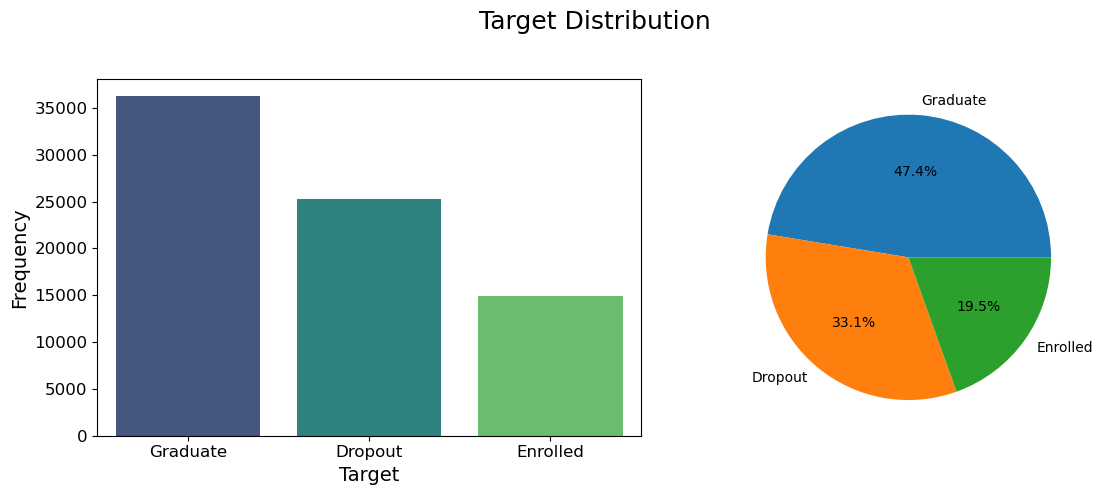

In [9]:
target_counts = train['Target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sb.barplot(
    x=target_counts.index,
    y=target_counts.values,
    hue=target_counts.index,
    palette="viridis",
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Pie chart
axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct='%1.1f%%'
)

fig.suptitle("Target Distribution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The categorical features are stored in the cat_vars array. All other attributes are numeric, except for the Target.

In [10]:
cat_vars = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
            'Previous qualification', 'Nacionality', "Mother's qualification",
            "Father's qualification", "Mother's occupation", "Father's occupation",
            'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
            'Gender', 'Scholarship holder', 'International']

num_features = [col for col in train.columns if col not in cat_vars + ['Target']]

Now we will plot the distributions of the dataset's features. For categorical and integer numeric features, a bar count plot is used, while for float numeric features we'll use an histogram instead.

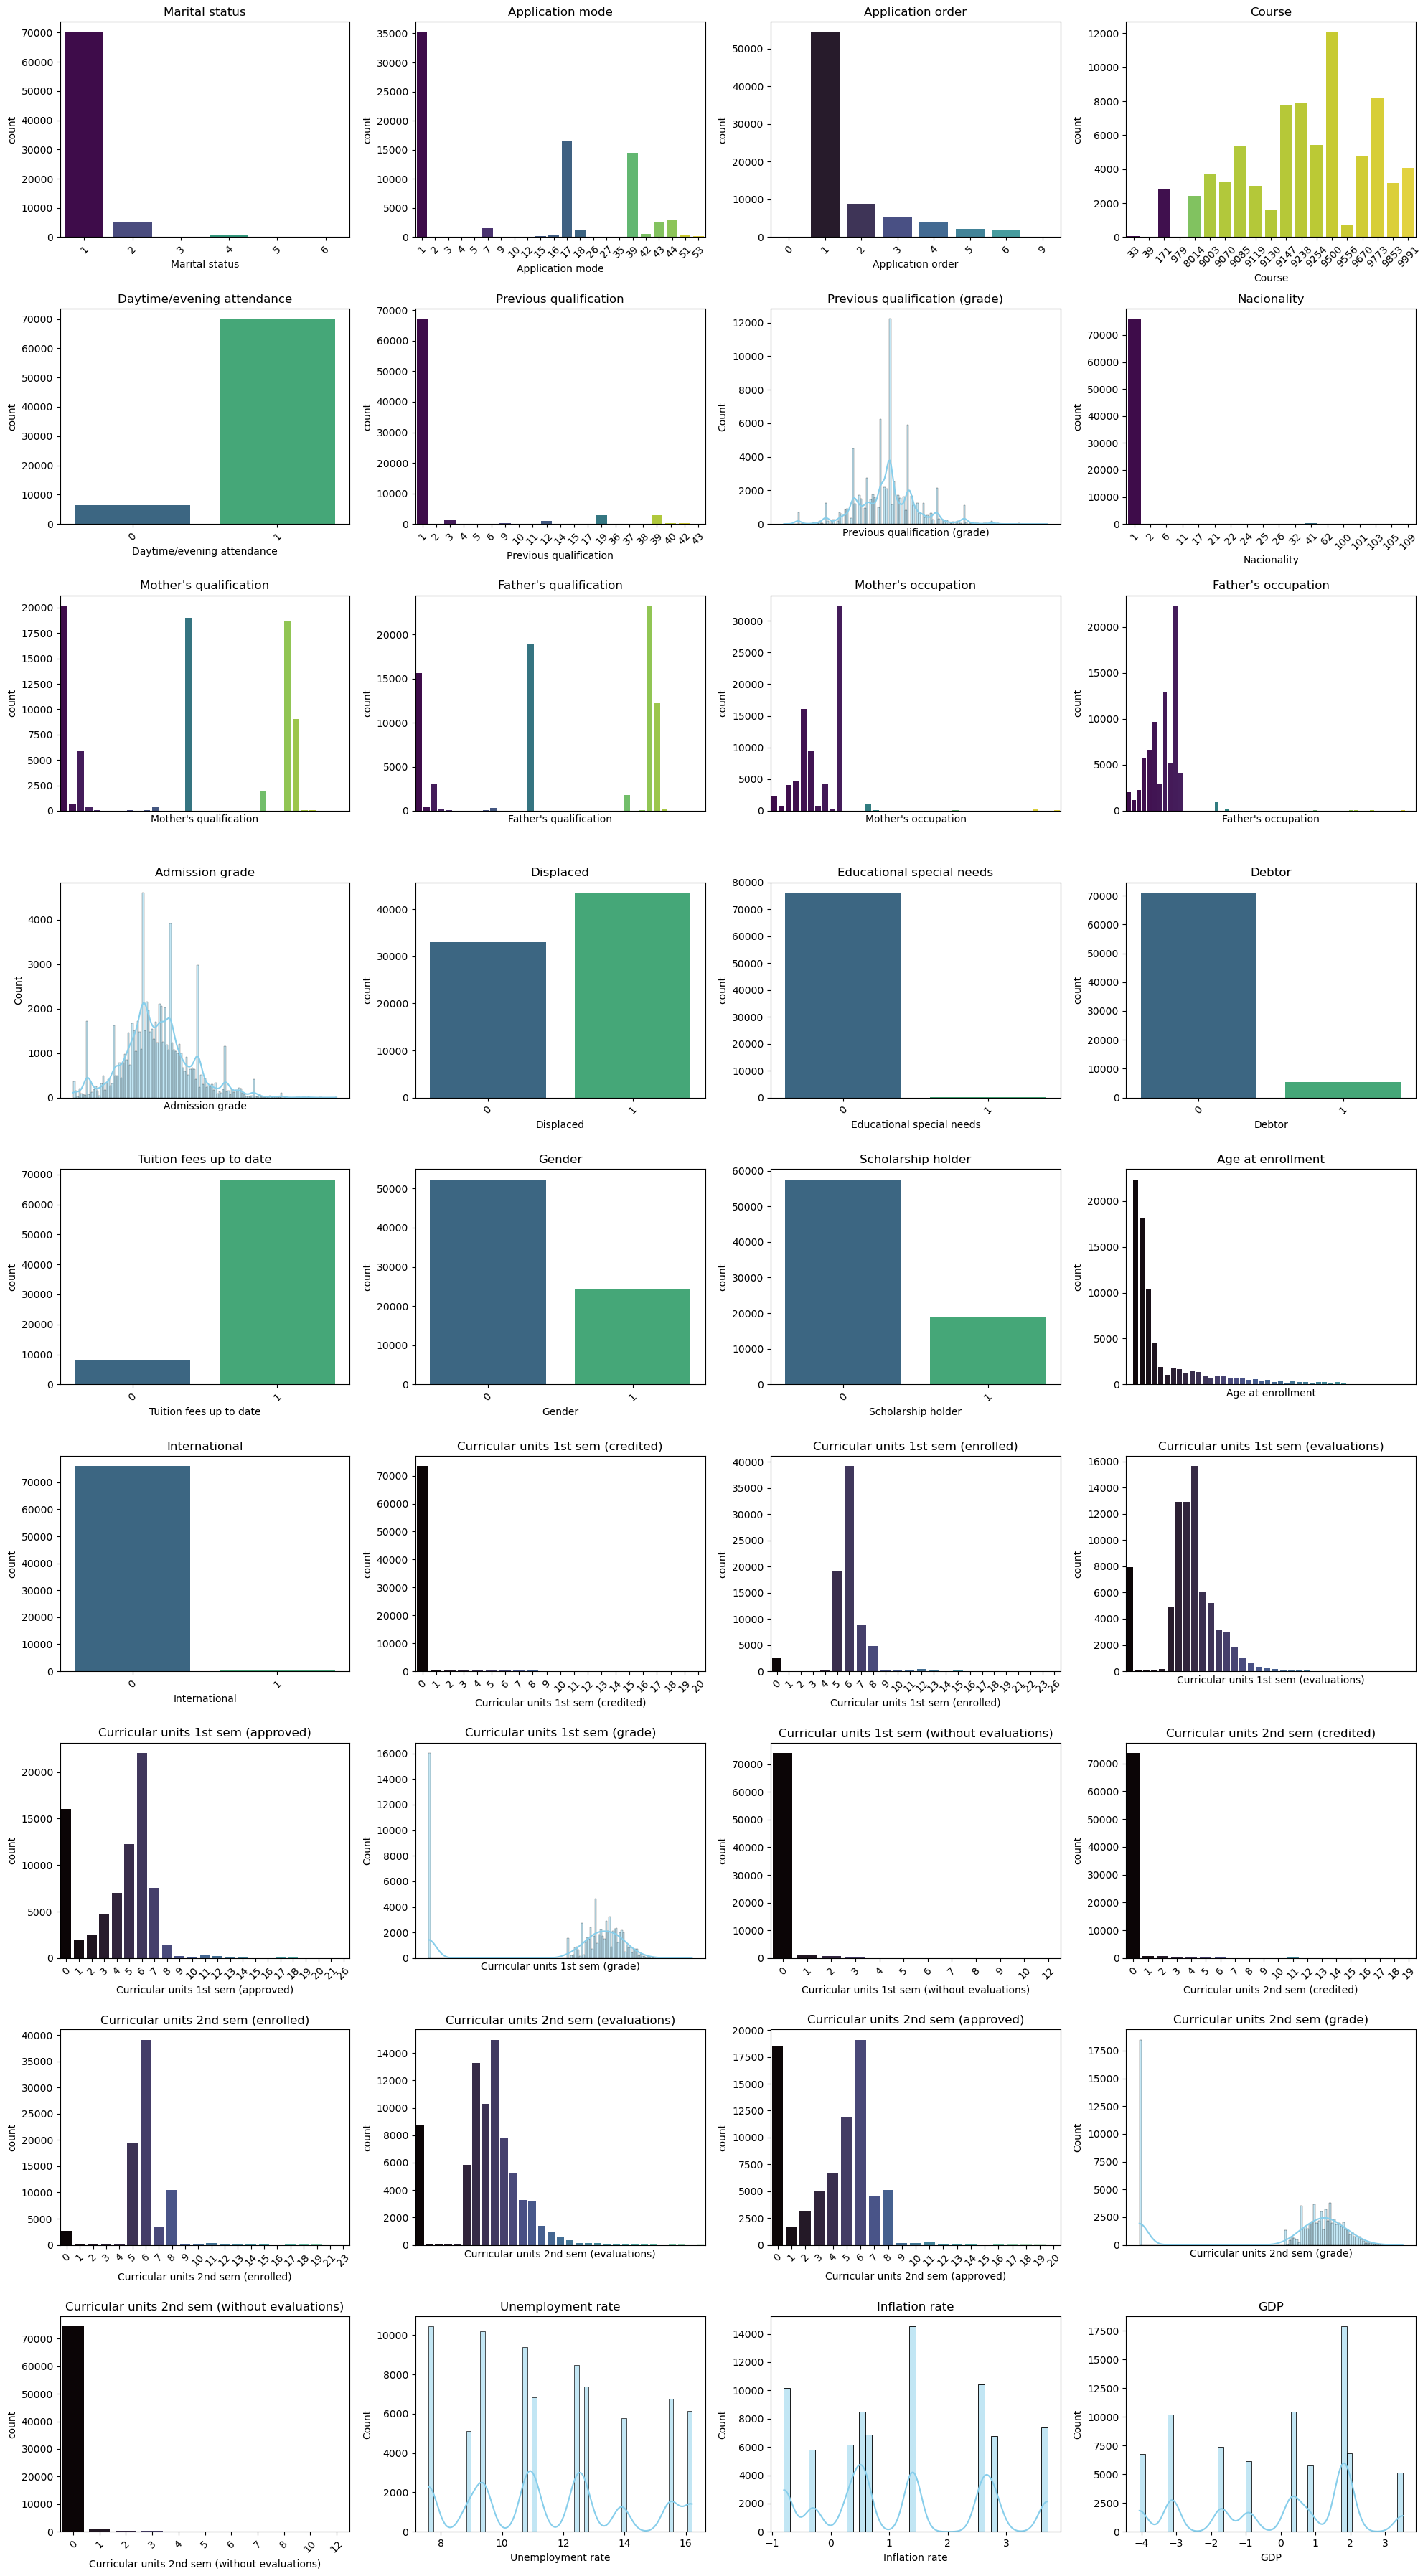

In [11]:
features_to_plot = [col for col in train.columns if col not in ['Target']]

n_cols = 4
n_rows = int(np.ceil(len(features_to_plot) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    unique_count = train[col].nunique()
    hide_xticks = unique_count > 25

    if col in cat_vars:
        sb.countplot(data=train, x=col, hue=col, palette="viridis", legend=False)
        if hide_xticks:
            plt.xticks([])
        else:
            plt.xticks(rotation=45)
    else:
        if train[col].dtype == 'int64':
            sb.countplot(data=train, x=col, hue=col, palette="mako", legend=False)
            if hide_xticks:
                plt.xticks([])
            else:
                plt.xticks(rotation=45)
        elif train[col].dtype == 'float64':
            sb.histplot(train[col], kde=True, color="skyblue")
            if hide_xticks:
                plt.xticks([])
    plt.title(col)
    plt.tight_layout()

plt.show()

From the above figure we can see that several features, such as 'Marital status' and 'Nationality', are highly imbalanced.

The figure below includes the violin plots of the numeric features of the dataset.

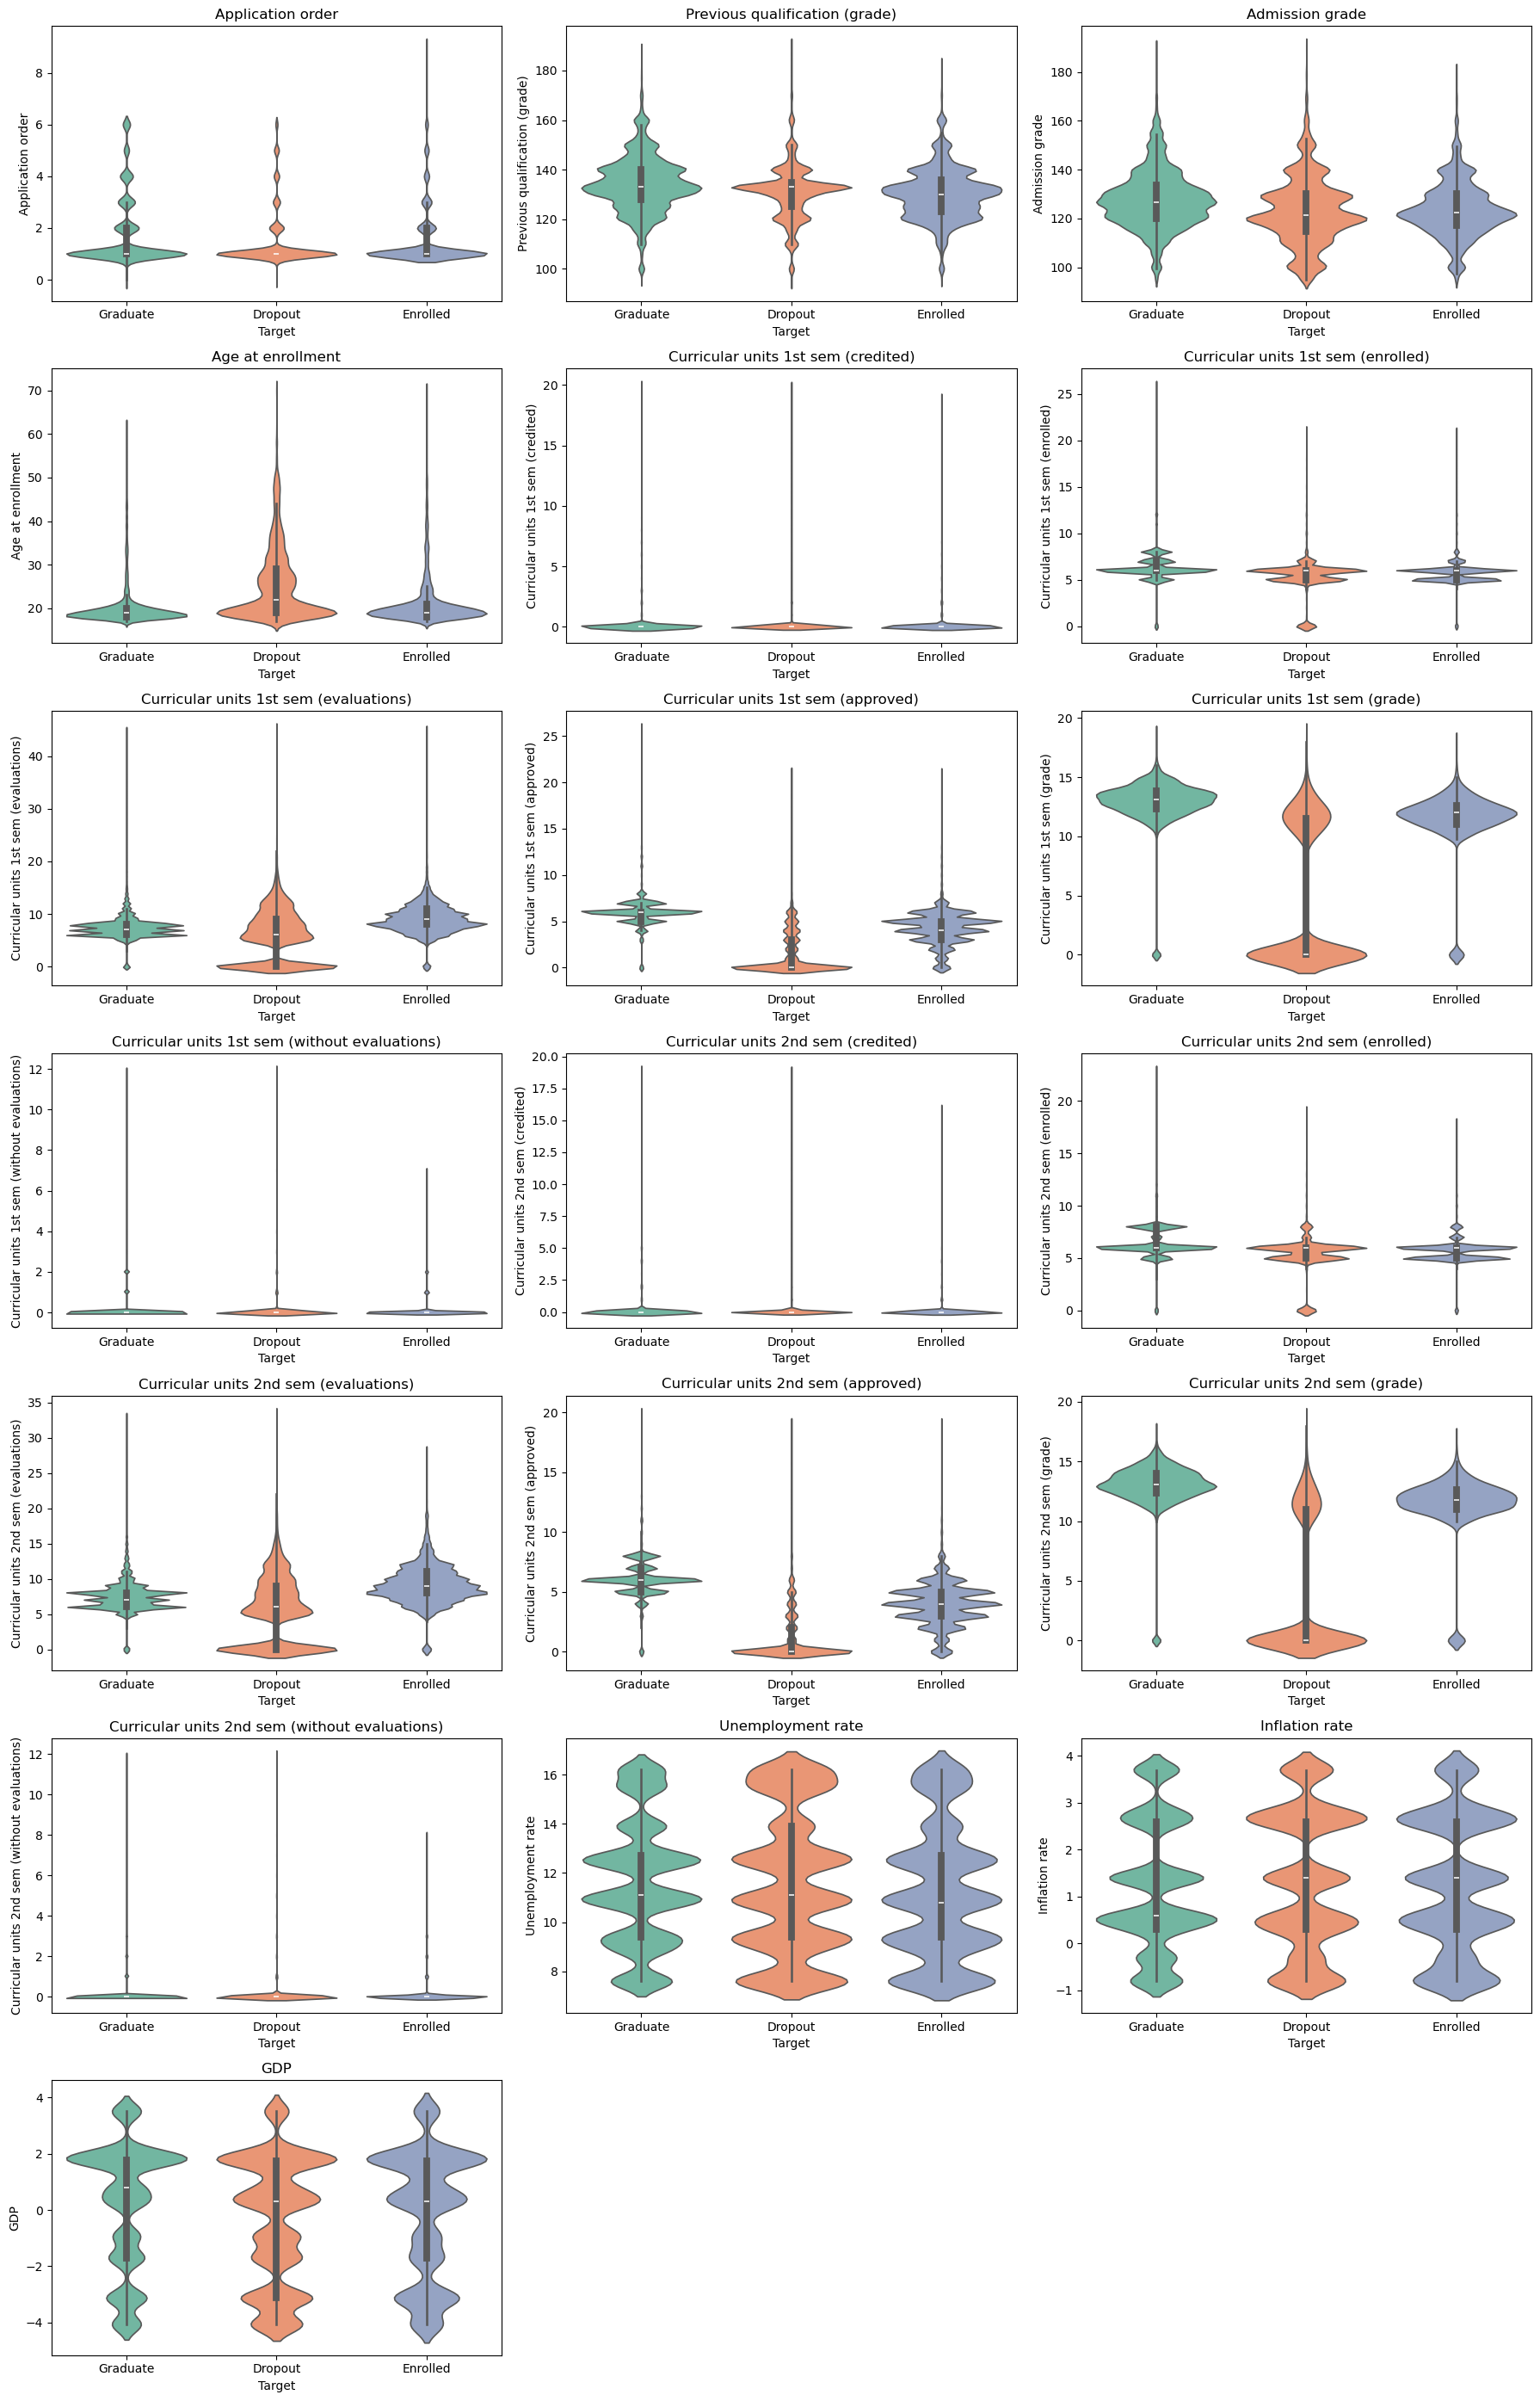

In [12]:
n_cols = 3
n_rows = int(np.ceil(len(num_features) / n_cols))
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, feature in enumerate(num_features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sb.violinplot(data=train, x='Target', y=feature, hue='Target', palette="Set2", legend=False)
    plt.title(feature)

plt.tight_layout()
plt.show()

An interesting observation from the violin plots is that there is not a significant difference in socio-economical features among the different target classes. On the other hand, features related to academic performance, such as grades, are strong differentiators, suggesting that these are more predictive of student outcomes in this dataset.

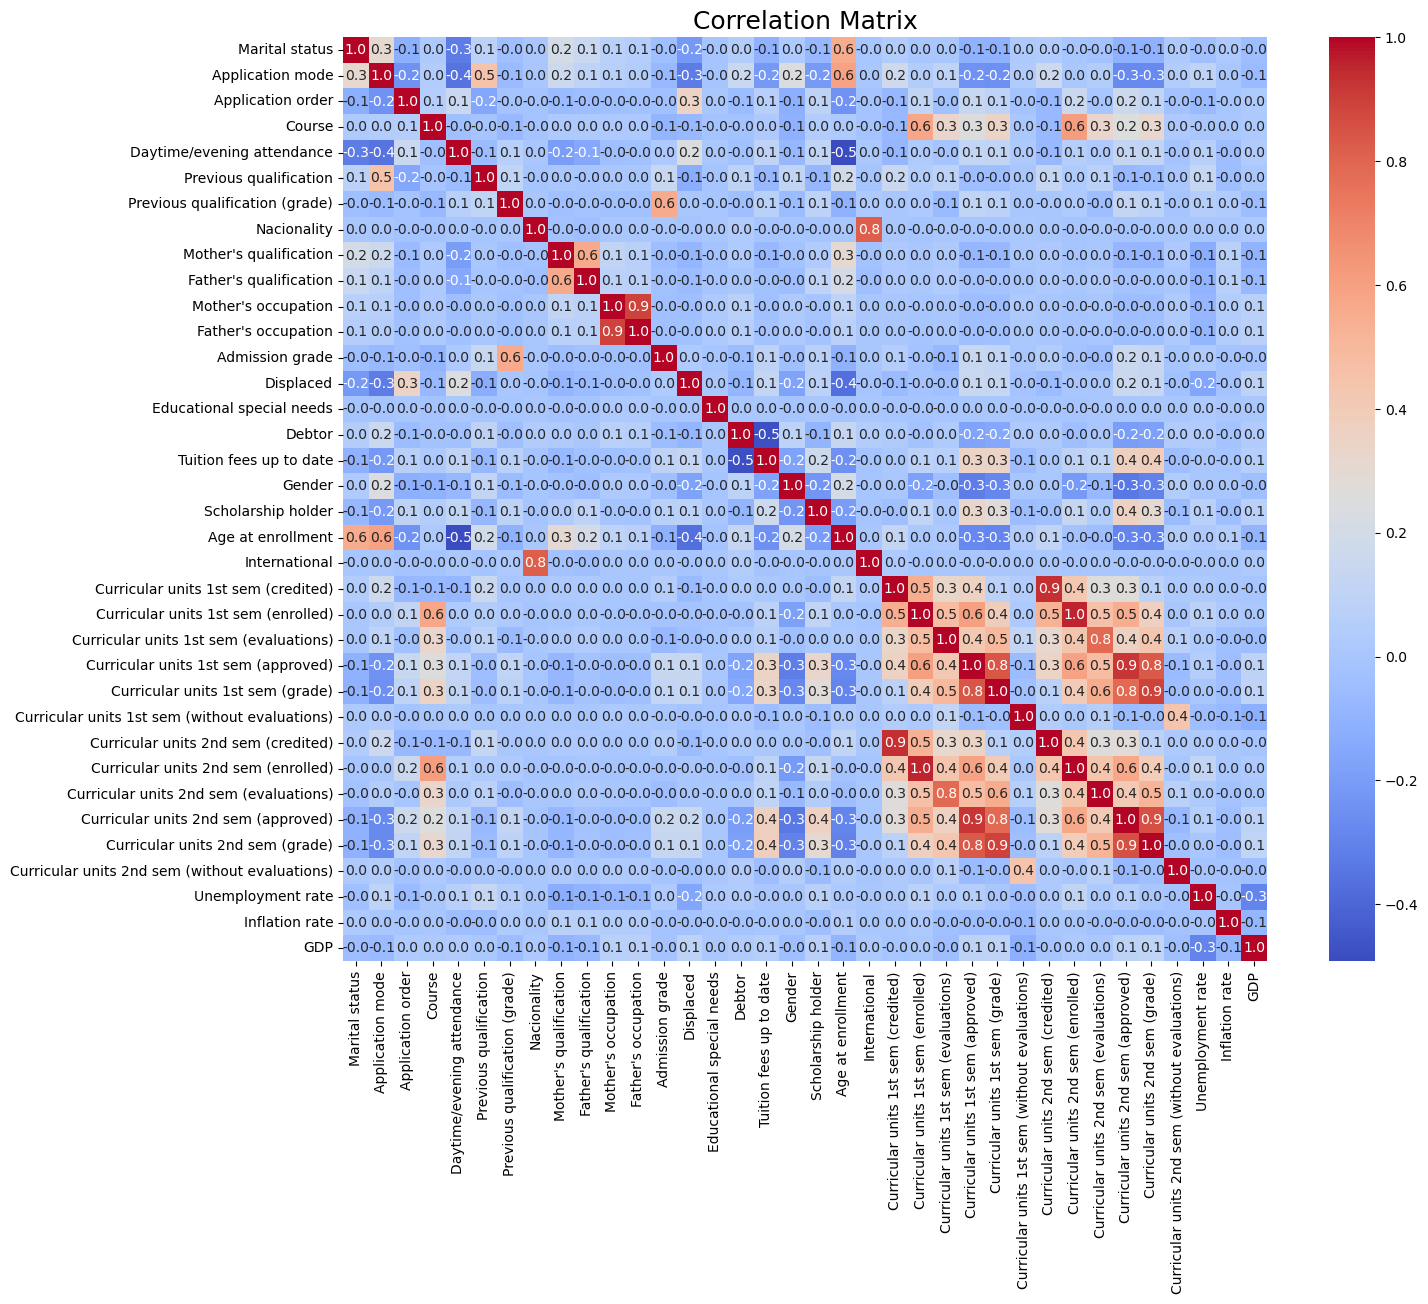

In [13]:
plt.figure(figsize=(16, 12))
corr_matrix = train.iloc[:, :-1].corr()
sb.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix", fontsize=18)
plt.show()

- There are strong correlations among features related to academic performance.
- Socio-economical features, namely 'Unemployment rate', 'Inflation rate' and 'GDP', have very low correlation with all other features.

## Data Preprocessing

Before training the models, we need to convert categorical data into a numerical format that machine learning algorithms can process. For the target variable (`Target`), we use a **Label Encoder** to assign each class a unique integer value. For the input categorical features, we apply **one-hot encoding** using `pd.get_dummies`, which creates a new binary column for each category, allowing the models to interpret categorical variables without assuming any ordinal relationship between them.

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])
print(train['Target'].unique())

# One-hot encoding for categorical variables
train = pd.get_dummies(train, columns=cat_vars, drop_first=True)

[2 0 1]


[2 0 1]
Dropout -> 0
Enrolled -> 1
Graduate -> 2

To evaluate model performance, we split the dataset into training and testing sets using `train_test_split`. The training set is used to fit the models, while the test set is reserved for evaluating how well the models generalize to unseen data. This helps prevent overfitting and provides a more accurate estimate of real-world performance.

In [15]:
from sklearn.model_selection import train_test_split

X = train.drop('Target', axis=1)
y = train['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (61214, 274)
Test set shape: (15304, 274)


Some of the algorithms we will use perform better when numeric features are on a similar scale. To achieve this, we use **StandardScaler** to standardize the numeric features so that they have a mean of 0 and a standard deviation of 1. This helps improve model convergence and ensures that features contribute equally to the learning process.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = X_train.copy()
X_test_s = X_test.copy()

X_train_s[num_features] = scaler.fit_transform(X_train[num_features])
X_test_s[num_features] = scaler.transform(X_test[num_features])

## Models

### Decision Tree

Evaluating max_depths: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


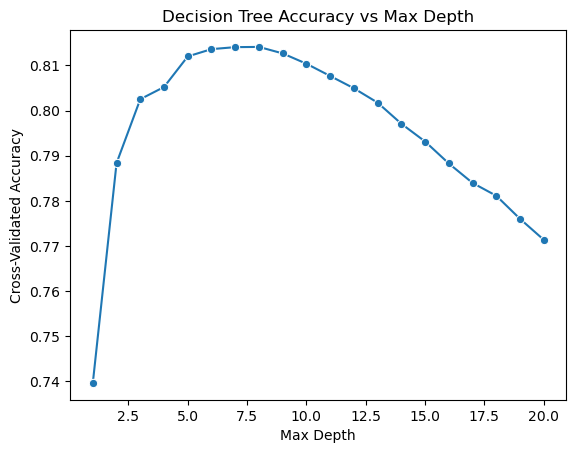

In [17]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

max_depths = range(1, 21)
dt_scores = []

for depth in tqdm(max_depths, desc="Evaluating max_depths"):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    score = cross_val_score(dt, X_train, y_train, cv=5)
    dt_scores.append(np.mean(score))

sb.lineplot(x=max_depths, y=dt_scores, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Decision Tree Accuracy vs Max Depth")
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_depth = int(np.argmax(dt_scores)) + 1
dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Best max_depth:", best_depth)
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)
print("Confusion Matrix:\n", cm_dt)

Best max_depth: 8
Accuracy: 0.8147543125980136
Precision: 0.816942945404814
Recall: 0.8147543125980136
F1 Score: 0.8137158261471032
Confusion Matrix:
 [[4025  658  376]
 [ 294 1784  910]
 [ 104  493 6660]]


### Multi-layer Perceptron (MLP) Classifier

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

mlp_hidden_sizes = [(50,), (100,), (150,), (100, 50), (100, 100)]
mlp_scores = []
for h in tqdm(mlp_hidden_sizes, desc="Evaluating hidden_layer_sizes"):
    mlp = MLPClassifier(hidden_layer_sizes=h, max_iter=100, random_state=42)
    score = cross_val_score(mlp, X_train_s, y_train, cv=3)
    mlp_scores.append(np.mean(score))

Evaluating hidden_layer_sizes:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
Evaluating hidden_layer_sizes:  20%|██        | 1/5 [02:29<09:59, 149.78s/it]c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (

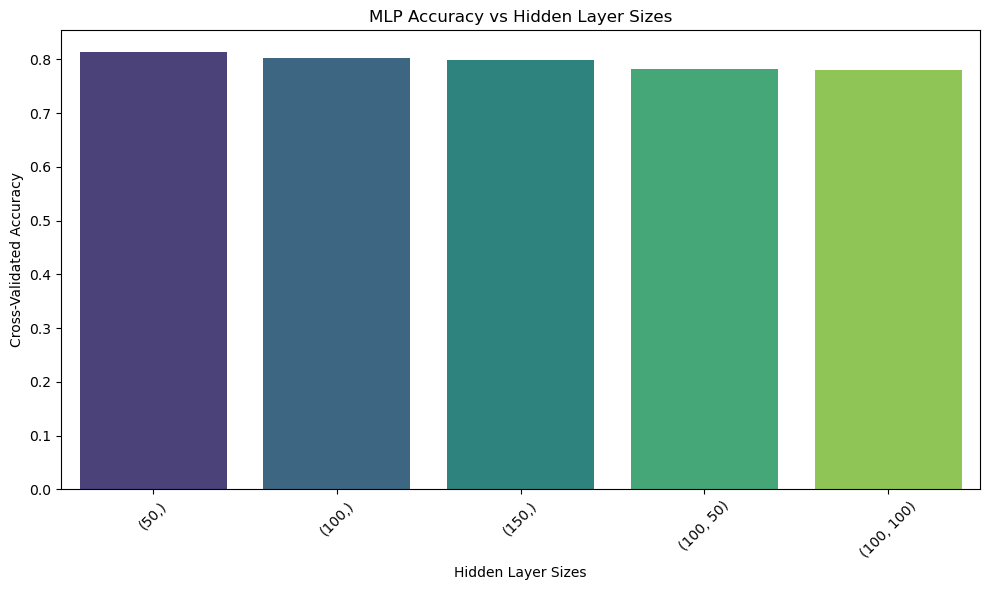

In [24]:
results_df = pd.DataFrame({
    "Hidden Layer Sizes": [str(h) for h in mlp_hidden_sizes],
    "Accuracy": mlp_scores
})

plt.figure(figsize=(10, 6))
sb.barplot(data=results_df, x="Hidden Layer Sizes", y="Accuracy", hue="Hidden Layer Sizes", dodge=False, palette="viridis", legend=False)
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Cross-Validated Accuracy")
plt.title("MLP Accuracy vs Hidden Layer Sizes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
from sklearn.neural_network import MLPClassifier

best_idx = np.argmax(mlp_scores)
best_hidden = mlp_hidden_sizes[best_idx]

mlp = MLPClassifier(hidden_layer_sizes=best_hidden, max_iter=100, random_state=42)
mlp.fit(X_train_s, y_train)
y_pred_mlp = mlp.predict(X_test_s)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

print("Accuracy:", accuracy_mlp)
print("Precision:", precision_mlp)
print("Recall:", recall_mlp)
print("F1 Score:", f1_mlp)
print("Confusion Matrix:\n", cm_mlp)

Accuracy: 0.8204391008886566
Precision: 0.8165195968208674
Recall: 0.8204391008886566
F1 Score: 0.8178089369783776
Confusion Matrix:
 [[4256  487  316]
 [ 474 1727  787]
 [ 190  494 6573]]


c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### Random Forest Classifier

Best n_estimators: 200 (CV Accuracy: 0.8240)
Random Forest Test Results
Accuracy: 0.8265159435441715
Precision: 0.8237361141842259
Recall: 0.8265159435441715
F1 Score: 0.8229994873152829
Confusion Matrix:
 [[4148  543  368]
 [ 355 1732  901]
 [ 129  359 6769]]


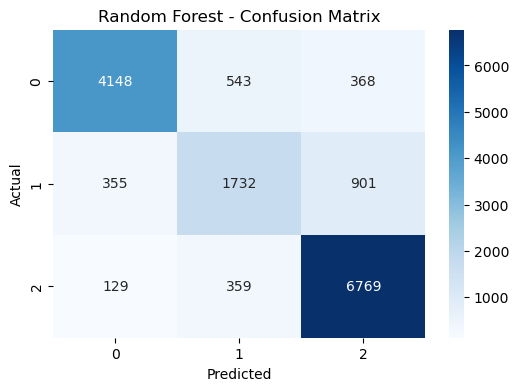

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

n_estimators_list = [50, 100, 150, 200]
cv_scores = []

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_idx = np.argmax(cv_scores)
best_n = n_estimators_list[best_idx]
print(f"Best n_estimators: {best_n} (CV Accuracy: {cv_scores[best_idx]:.4f})")

rf_model = RandomForestClassifier(n_estimators=best_n, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')
cm_rf = confusion_matrix(y_test, y_pred)

print("Random Forest Test Results")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("Confusion Matrix:\n", cm_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Logistic Regression

Evaluating C values:  50%|█████     | 3/6 [00:23<00:25,  8.47s/it]c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Evaluating C values:  67%|██████▋   | 4/6 [00:36<00:20, 10.46s/it]c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

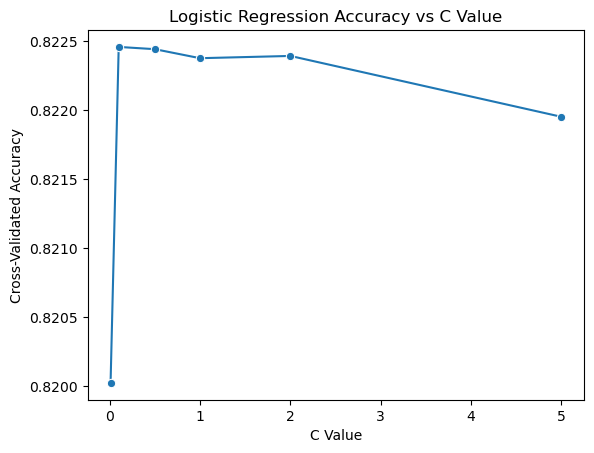

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_C_values = [0.01, 0.1, 0.5, 1, 2, 5]
lr_scores = []

for c in tqdm(lr_C_values, desc="Evaluating C values"):
    lr = LogisticRegression(C=c, max_iter=200, random_state=42)
    score = cross_val_score(lr, X_train_s, y_train, cv=3)
    lr_scores.append(np.mean(score))

sb.lineplot(x=lr_C_values, y=lr_scores, marker='o')
plt.xlabel("C Value")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Logistic Regression Accuracy vs C Value")
plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_idx = np.argmax(lr_scores)
best_c = lr_C_values[best_idx]

lr = LogisticRegression(C=best_c, max_iter=200, random_state=42)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"Best C value: {best_c}")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)
print("Confusion Matrix:\n", cm_lr)

Best C value: 0.1
Accuracy: 0.8227260846837429
Precision: 0.8186242930474819
Recall: 0.8227260846837429
F1 Score: 0.818728479035156
Confusion Matrix:
 [[4187  531  341]
 [ 375 1681  932]
 [ 168  366 6723]]


## Emsemble (Voting Classifier)

In [42]:
from sklearn.ensemble import VotingClassifier

dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
mlp_best = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
lr_best = LogisticRegression(max_iter=200, random_state=42)
rf_best = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('dt', dt_best),
        ('mlp', mlp_best),
        ('lr', lr_best),
        ('rf', rf_best)
    ],
    voting='soft'
)

ensemble.fit(X_train_s, y_train)
y_pred_ensemble = ensemble.predict(X_test_s)

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='weighted')
recall_ensemble = recall_score(y_test, y_pred_ensemble, average='weighted')
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

print("Ensemble Accuracy:", accuracy_ensemble)
print("Ensemble Precision:", precision_ensemble)
print("Ensemble Recall:", recall_ensemble)
print("Ensemble F1 Score:", f1_ensemble)
print("Ensemble Confusion Matrix:\n", cm_ensemble)

c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble Accuracy: 0.8279534762153685
Ensemble Precision: 0.8256033872457922
Ensemble Recall: 0.8279534762153685
Ensemble F1 Score: 0.8249673999360622
Ensemble Confusion Matrix:
 [[4180  528  351]
 [ 353 1750  885]
 [ 111  405 6741]]


## Overall Analysis and Comparison of Algorithms

In [34]:
summary_df = pd.DataFrame({
    'Algorithm': [
        'Decision Tree',
        'MLP',
        'Logistic Regression',
        'Ensemble (Voting)',
        'Random Forest'
    ],
    'Accuracy': [
        accuracy_dt,
        accuracy_mlp,
        accuracy_lr,
        accuracy_ensemble,
        accuracy_rf
    ],
    'Precision': [
        precision_dt,
        precision_mlp,
        precision_lr,
        precision_ensemble,
        precision_rf
    ],
    'Recall': [
        recall_dt,
        recall_mlp,
        recall_lr,
        recall_ensemble,
        recall_rf
    ],
    'F1 Score': [
        f1_dt,
        f1_mlp,
        f1_lr,
        f1_ensemble,
        f1_rf
    ]
})
summary_df

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.814754,0.816943,0.814754,0.813716
1,MLP,0.820439,0.816520,0.820439,0.817809
2,Logistic Regression,0.822726,0.818624,0.822726,0.818728
3,Ensemble (Voting),0.827953,0.825603,0.827953,0.824967
4,Random Forest,0.826516,0.823736,0.826516,0.822999


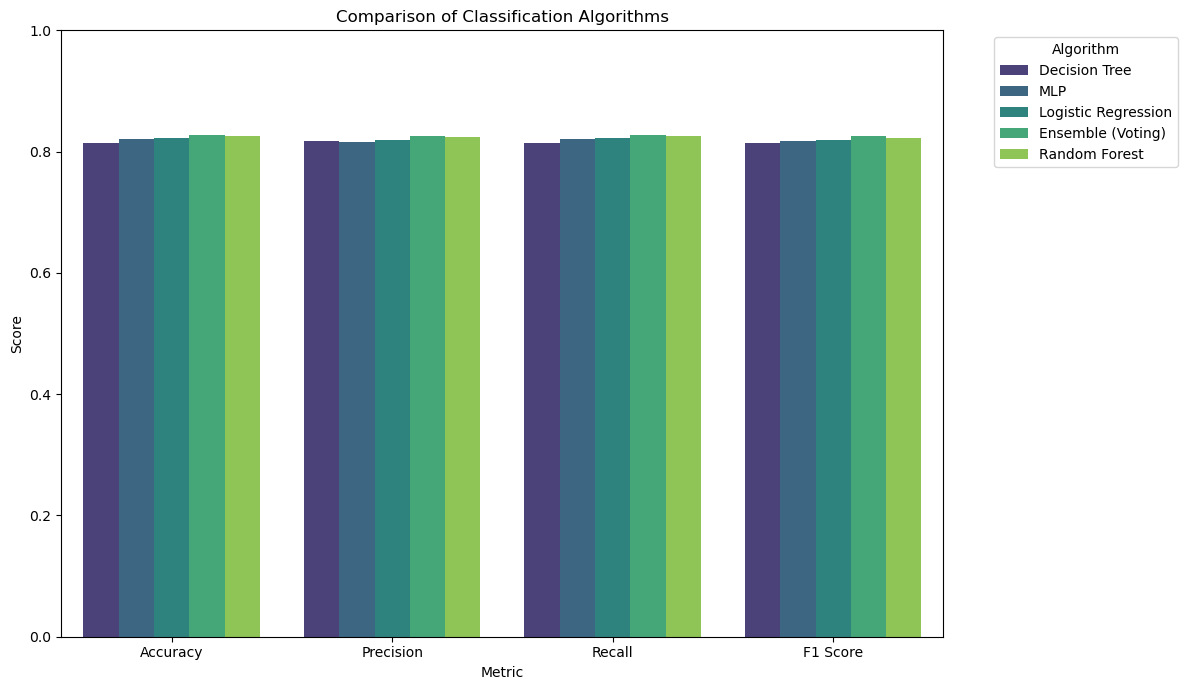

In [35]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 7))
summary_melted = summary_df.melt(id_vars='Algorithm', value_vars=metrics, var_name='Metric', value_name='Score')
sb.barplot(data=summary_melted, x='Metric', y='Score', hue='Algorithm', palette='viridis')
plt.title('Comparison of Classification Algorithms')
plt.ylim(0, 1)
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

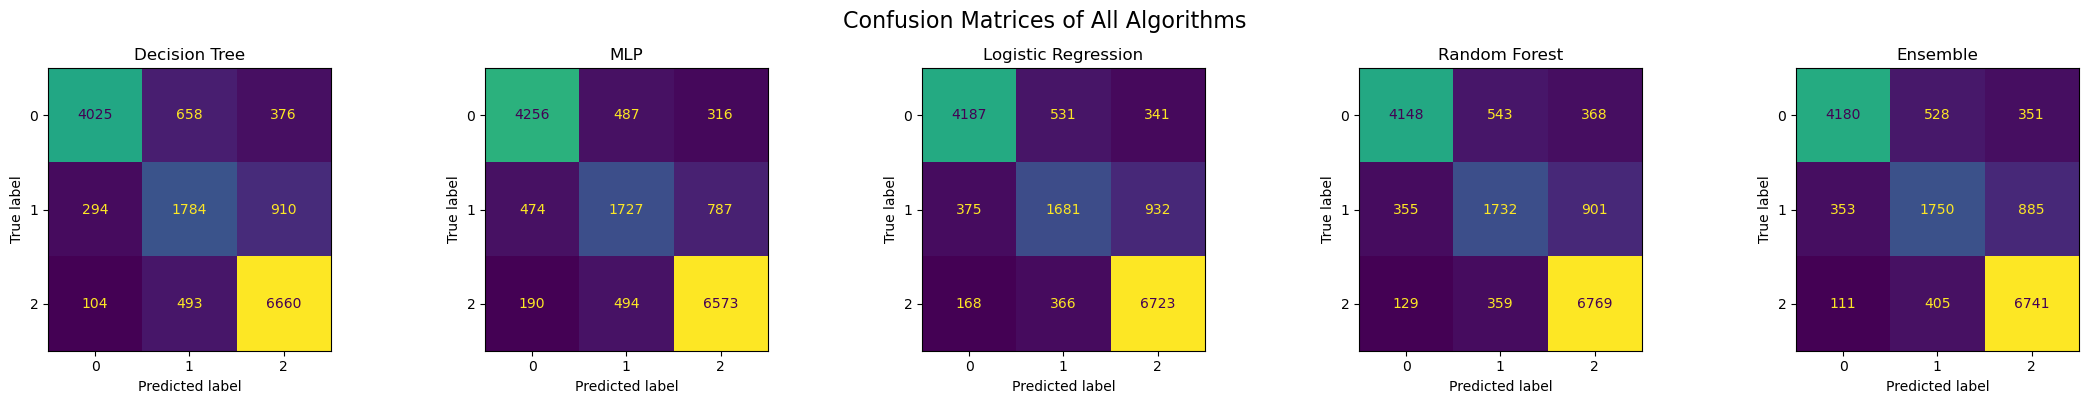

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
algorithms = ['Decision Tree', 'MLP', 'Logistic Regression', 'Random Forest', 'Ensemble']
cms = [cm_dt, cm_mlp, cm_lr, cm_rf, cm_ensemble]
for ax, name, cmatrix in zip(axes, algorithms, cms):
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.suptitle('Confusion Matrices of All Algorithms', fontsize=16)
plt.tight_layout()
plt.show()

## Additional Analysis: Learning Curve and ROC Curve for Random Forest

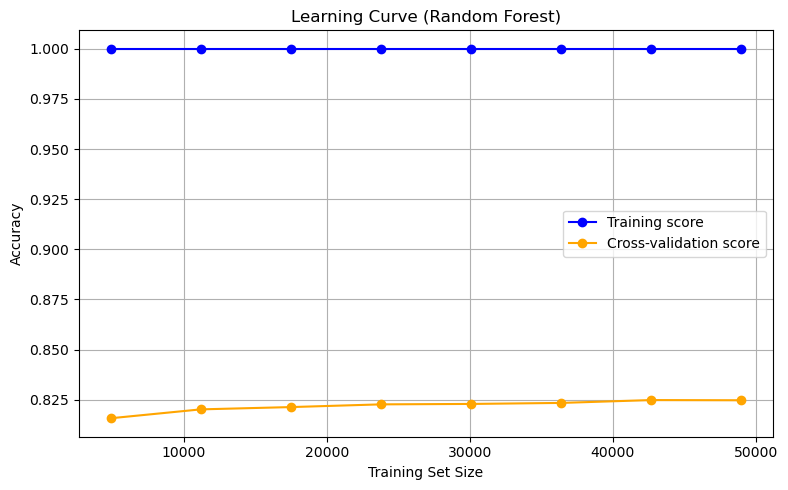

In [39]:
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Learning Curve for Random Forest
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=best_n, random_state=42),
    X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True,
    random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Cross-validation score')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

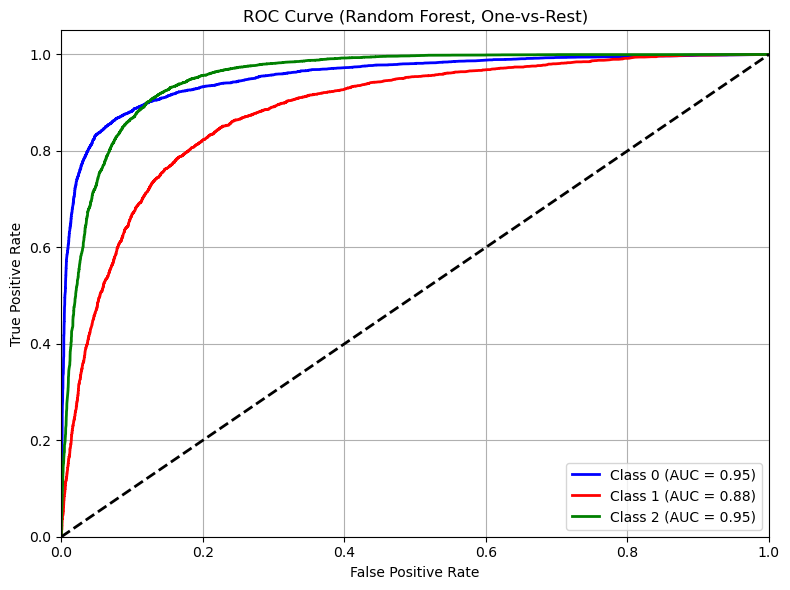

In [40]:
# ROC Curve for Random Forest (One-vs-Rest, multi-class)
n_classes = len(np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
rf_ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_n, random_state=42))
rf_ovr.fit(X_train, y_train)
y_score = rf_ovr.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest, One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion

The accuracy of our models was primarily driven by several key factors:

- **Feature Importance & Interpretation:** Academic performance indicators (such as grades and course progress) were the strongest predictors of student outcomes. This was demonstrated through exploratory data analysis (violin plots, correlation heatmaps).

- **Data Preprocessing & Engineering:** We applied robust preprocessing steps, including normalization of numeric features, one-hot encoding of categorical variables, and a train-test split. These steps ensured that all models could learn effectively and fairly from the data.

- **Model Selection & Evaluation:** We systematically compared a variety of algorithms, including Decision Tree, MLP, Logistic Regression, Random Forest, and an Ensemble Voting Classifier. Hyperparameter tuning and cross-validation were used to optimize each model, and we evaluated them using multiple metrics (accuracy, precision, recall, F1 score) and confusion matrices for a comprehensive assessment.

- **Visualization & Communication:** Throughout the notebook, we used advanced data visualization techniques (bar plots, violin plots, heatmaps, confusion matrices) to model results clearly.

- **Cross-Validation & Generalization:** By employing cross-validation, we ensured model stability and reduced the risk of overfitting, leading to results that generalize well to unseen data.

### Summary of Results 

- The summary table and bar plots clearly show that Random Forest and the Ensemble Voting Classifier achieved the highest metrics across accuracy, precision, recall, and F1 score. This happened since the ensemble effectively combines the strengths of the various models, leading to better generalization, while random forest works well with many features and leverages what was already a strong learner on its own - the decision tree.
- Confusion matrices indicate that these models made fewer misclassifications across all classes, especially for the minority classes, again for the same reason of combining multiple models.

In other words, each model performed well in its own way, but some were better than others. By combining their strengths and reducing their weaknesses using an ensemble approach, we achieved even better results. The Voting Classifier, which brings together the predictions of several models, reached the highest accuracy and F1 score. This shows that using ensemble methods can be very effective, especially in complex classification problems like this one.

### Final Thoughts

In summary, the combination of strong feature selection, robust preprocessing, and the use of ensemble models were the main contributors to our high accuracy.